# Imports, requête et nettoyage

In [29]:
# imports

import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine, engine
from sqlalchemy_utils import database_exists, create_database
from sklearn import preprocessing
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from minisom import MiniSom
import pickle

def read_pickle(file_path):
    objects = []
    with (open(file_path, "rb")) as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects[0]

# modules
def read_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# test
def test_db_config(db_config):
    """
    Test if the database config is valid
    """

    s = f"postgresql://{db_config['user']}:{db_config['pass']}@{db_config['host']}:{db_config['port']}/postgres"
    db_engine = create_engine(s)

    assert type(db_engine.connect()) == engine.base.Connection

# read config
db_config = read_json("keys/database_config.json")

# test database connection with config
test_db_config(db_config)
print("- Connection to db created successfully with current config")

# Create engine. Make sure the current IP address is withelisted on Azure.
s = f"postgresql://{db_config['user']}:{db_config['pass']}@{db_config['host']}:{db_config['port']}/an_database"
an_engine = create_engine(s)

- Connection to db created successfully with current config


In [30]:
query = """
    SELECT * FROM profiles
    JOIN profiles_kpis ON profiles.profile_id = profiles_kpis.profile_id
"""

df_profiles = pd.read_sql(query,an_engine)
df_profiles.drop('profile_id',axis=1,inplace=True)
df_profiles.head(20)

,genre,age,revenus,localisation,ca,commandes,panier_moyen,prix_moyen_article,clients,nb_articles_moyen,frequence
0,Femme,18-24,CSP moins,Très urbain,51503.269416,928.496894,54.143276,40.431653,750.146705,1.415168,1.619840
1,Femme,18-24,CSP moyen,Très urbain,26462.056050,477.813439,53.812686,40.004087,385.711183,1.419154,1.650473
2,Femme,18-24,CSP plus,Très urbain,35576.056214,640.514657,53.992378,40.499329,517.355698,1.399364,1.630459
3,Femme,18-24,CSP moins,Très rural,14030.376582,245.241309,55.218403,42.111052,201.661046,1.398460,1.536289
4,Femme,18-24,CSP moyen,Très rural,10738.769284,186.788709,56.402980,42.641786,154.486127,1.411537,1.459353
5,Femme,18-24,CSP plus,Très rural,8143.977506,139.798292,58.124413,43.201481,115.673010,1.425455,1.485414
6,Femme,18-24,CSP moins,Urbain,24425.430127,439.566736,53.994363,41.233375,362.903372,1.402084,1.465628
7,Femme,18-24,CSP moyen,Urbain,16003.268180,287.305282,54.757529,41.308634,235.059210,1.400475,1.547464
8,Femme,18-24,CSP plus,Urbain,14879.592955,269.328511,52.941337,39.869903,220.463472,1.390395,1.536217
9,Femme,18-24,CSP moins,Rural,20330.076240,351.119826,56.458179,42.826173,276.241445,1.398191,1.940766


In [31]:
# Test valeur null
for col in df_profiles.columns:
    
    if df_profiles[col].isnull().values.any():
        print(col, end=' ')
        print("Contient des valeurs null")
    else:
        print(col, end=' ')
        print('OK')

genre OK
age OK
revenus OK
localisation OK
ca OK
commandes OK
panier_moyen OK
prix_moyen_article OK
clients OK
nb_articles_moyen OK
frequence OK


## Encodage des valeurs catégorielles

In [32]:
df_profiles_encoded = df_profiles.copy()

# Encodage des variables catégorielles
df_profiles_encoded['age'] = df_profiles_encoded['age'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2)
df_profiles_encoded['revenus'] = df_profiles_encoded['revenus'].replace({'CSP moins':20000,'CSP moyen':40000,'CSP plus':60000})
df_profiles_encoded[['Femme','Homme']] = pd.get_dummies(df_profiles_encoded['genre'], prefix='')
df_profiles_encoded[['Rural','Très rural','Très urbain','Urbain']] = pd.get_dummies(df_profiles_encoded['localisation'], prefix='')

# Sélection des colonnes
df_profiles_encoded = df_profiles_encoded[[
    'age',
    'revenus',
    'Femme',
    'Homme',
    'Rural',
    'Très rural',
    'Très urbain',
    'Urbain',
    'ca',
    'commandes',
    'panier_moyen',	'prix_moyen_article',
    'clients',
    'nb_articles_moyen',
    'frequence'
]]

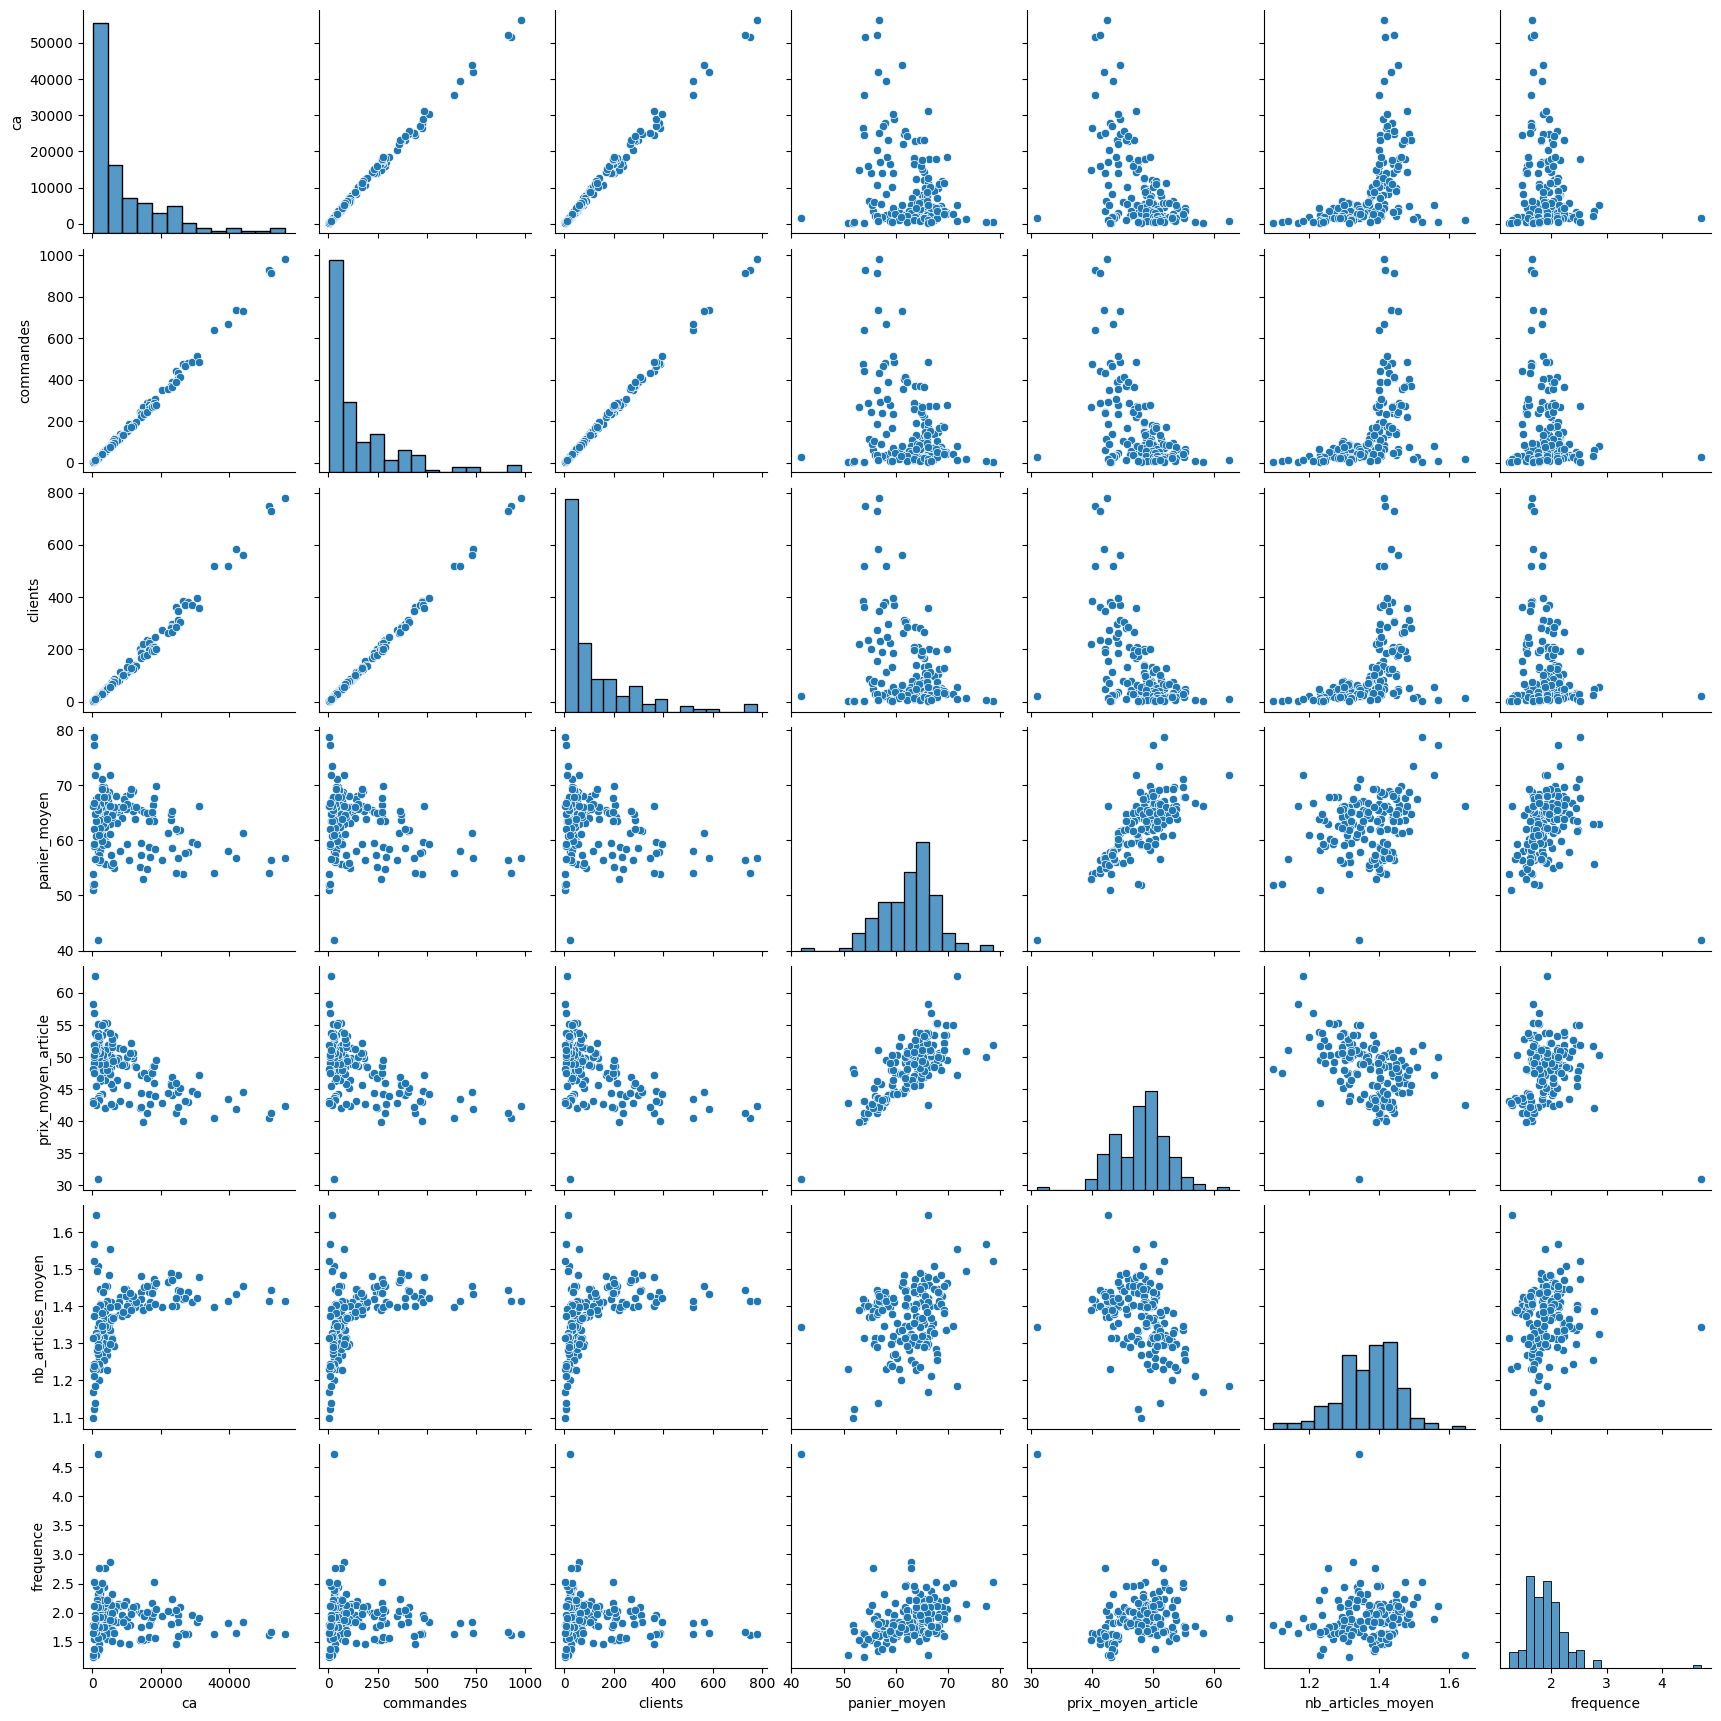

In [29]:
import seaborn as sns

data = df_profiles_encoded[['ca','commandes','clients','panier_moyen','prix_moyen_article','nb_articles_moyen','frequence']]
sns.pairplot(data)

In [33]:
df_profiles_scaled = df_profiles_encoded.copy()

# Standardisation des variables quantitatives
cols_to_standardize = [
    'panier_moyen',
    'prix_moyen_article',
    'nb_articles_moyen',
    'frequence'
]

scaler = preprocessing.StandardScaler()
df_profiles_scaled[cols_to_standardize] = scaler.fit_transform(df_profiles_scaled[cols_to_standardize])

# Normalisation des variables quantitatives
cols_to_normalize = [
    'age',
    'revenus',
    'ca',
    'commandes',
    'clients'
]

scaler = preprocessing.MinMaxScaler()
df_profiles_scaled[cols_to_normalize] = scaler.fit_transform(df_profiles_scaled[cols_to_normalize])


# KMeans

In [30]:
df_resultats = pd.DataFrame(columns=['n_clusters','silhouette_score','inertia'])

i=0

for n_clusters in range(2,11):

    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit_predict(df_profiles_scaled)

    # Evaluate KMeans
    df_resultats.loc[i,'n_clusters'] = n_clusters
    df_resultats.loc[i,'silhouette_score'] = silhouette_score(df_profiles_scaled, kmeans.labels_)
    df_resultats.loc[i,'inertie'] = kmeans.inertia_

    i+=1

In [34]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(df_profiles_scaled)

df_profiles['cluster'] = clusters

In [35]:
import pickle

with open('kmeans', 'wb') as f:
    pickle.dump(kmeans, f)

<AxesSubplot:xlabel='n_clusters', ylabel='inertie'>

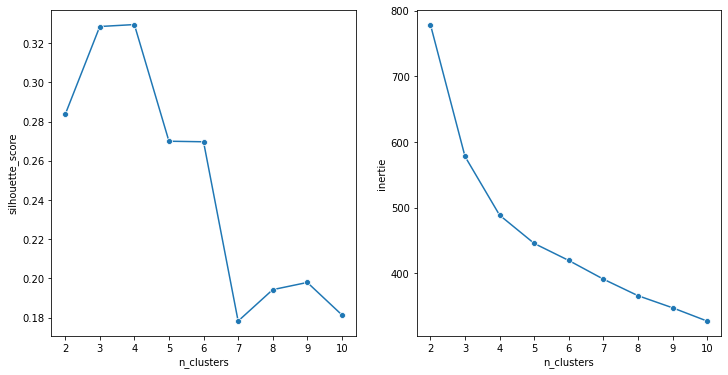

In [35]:
plt.figure(figsize=[12,6])

plt.subplot(121)
sns.lineplot(data=df_resultats, x="n_clusters", y="silhouette_score", marker='o')
plt.subplot(122)
sns.lineplot(data=df_resultats, x="n_clusters", y="inertie", marker='o')

<Figure size 720x720 with 0 Axes>

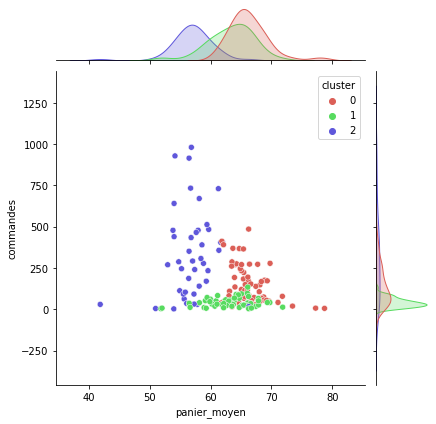

In [41]:
plt.figure(figsize=[10,10])
sns.color_palette("hls", 8)
sns.jointplot(data=df_profiles, x='panier_moyen',y='commandes', hue='cluster', palette=sns.color_palette("hls", 3))

# DBSCAN

In [66]:
df_to_cluster = df_profiles_scaled[['ca','commandes','panier_moyen','prix_moyen_article','clients','nb_articles_moyen','frequence']].copy()

dbscan = DBSCAN(eps=1.5, min_samples=10, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None).fit(df_profiles_scaled)
labels = dbscan.labels_

In [172]:
import numpy as np
from sklearn.metrics import silhouette_score

i=0

df_resultats = pd.DataFrame(columns=['eps','min_samples','silhouette_score','nb_clusters'])
for min_samples in range(5,15):

    for eps in np.arange(0.7,1.8,0.005) :

        clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
        clustering.fit(df_profiles_scaled)
        labels = clustering.labels_
        df_profiles_scaled['cluster'] = labels

        df_resultats.loc[i,'eps']=round(eps,3)
        df_resultats.loc[i,'min_samples']=min_samples
        df_resultats.loc[i,'nb_-1'] = len(df_profiles_scaled[df_profiles_scaled['cluster']==-1])
        if len(set(labels)) > 1:
            df_resultats.loc[i,'silhouette_score']=silhouette_score(df_profiles_scaled, labels, metric='euclidean')
        else:
            df_resultats.loc[i,'silhouette_score']=0
        df_resultats.loc[i,'nb_clusters']=len(set(labels)) - (1 if -1 in labels else 0)

        i+=1

/Users/julienbosse/Code/Chef-d-oeuvre/venv/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


Text(0.5, 1.0, 'Silhouette score')

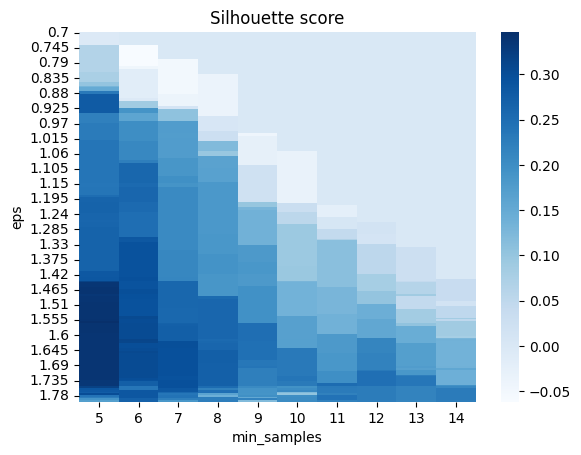

In [173]:
pivotted= df_resultats.pivot('eps','min_samples','silhouette_score').fillna(0)
# Heatmap

sns.heatmap(pivotted, cmap='Blues')
plt.title('Silhouette score')

Text(0.5, 1.0, 'Nombre de clusters')

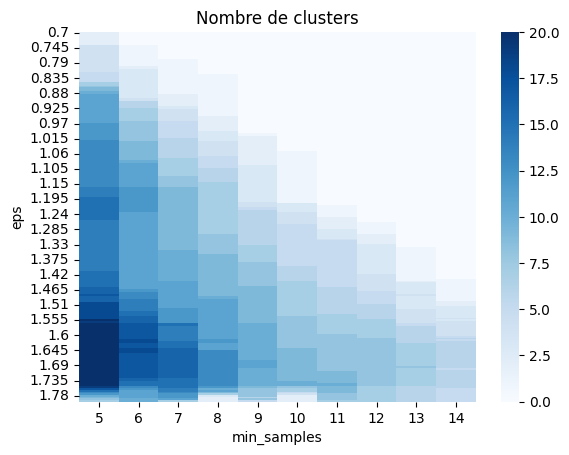

In [174]:
pivotted= df_resultats.pivot('eps','min_samples','nb_clusters').fillna(0)
# Heatmap

sns.heatmap(pivotted, cmap='Blues')
plt.title('Nombre de clusters')

Text(0.5, 1.0, 'Nombre de points "bruits"')

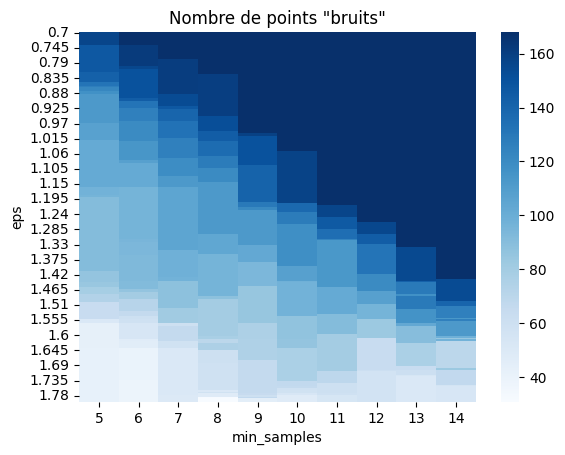

In [175]:
pivotted= df_resultats.pivot('eps','min_samples','nb_-1').fillna(0)
# Heatmap

sns.heatmap(pivotted, cmap='Blues')
plt.title('Nombre de points "bruits"')

Text(0.5, 1.0, 'Nombre de points "bruits"')

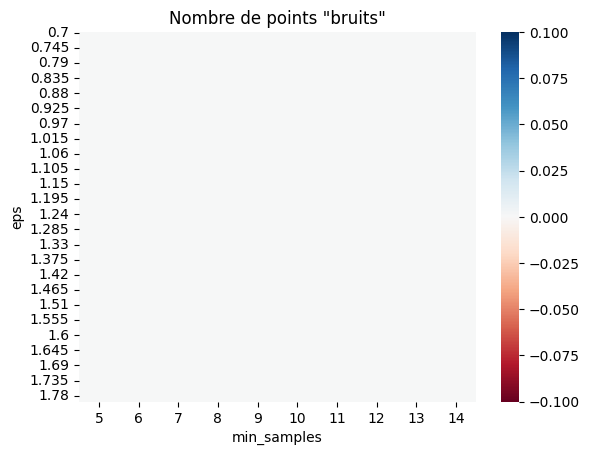

In [144]:
for col in pivotted.columns:
    pivotted[col].values[:] = 0

sns.heatmap(pivotted, cmap='RdBu')
plt.title('Nombre de points "bruits"')

In [36]:
clustering = DBSCAN(eps=1.11, min_samples=8, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clustering.fit(df_profiles_scaled)
labels = clustering.labels_
df_profiles['cluster'] = labels

In [37]:
with open('dbscan', 'wb') as f:
    pickle.dump(clustering, f)

In [21]:
dbscan = read_pickle('../app/static/models/dbscan_model')

In [22]:
dbscan.labels_

array([ 0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1,
       -1, -1, -1, -1,  2,  2,  2,  0,  0, -1,  1,  1,  1, -1,  3,  3,  2,
        2,  2, -1, -1, -1,  1,  1,  1,  3,  3,  3,  2,  2, -1, -1, -1, -1,
        1,  1,  1,  3,  3, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  3,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  5, -1, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1,  5,
        5, -1, -1, -1,  4,  4,  4, -1, -1, -1,  5,  5,  5, -1, -1, -1,  4,
        4,  4, -1, -1, -1,  5,  5, -1, -1, -1, -1, -1,  4,  4, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

<Figure size 720x720 with 0 Axes>

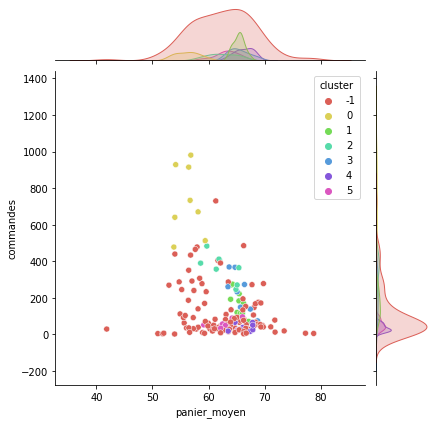

In [10]:
plt.figure(figsize=[10,10])
sns.jointplot(data=df_profiles, x='panier_moyen',y='commandes', hue='cluster', palette=sns.color_palette("hls", len(set(df_profiles['cluster'] ))))

# SOM

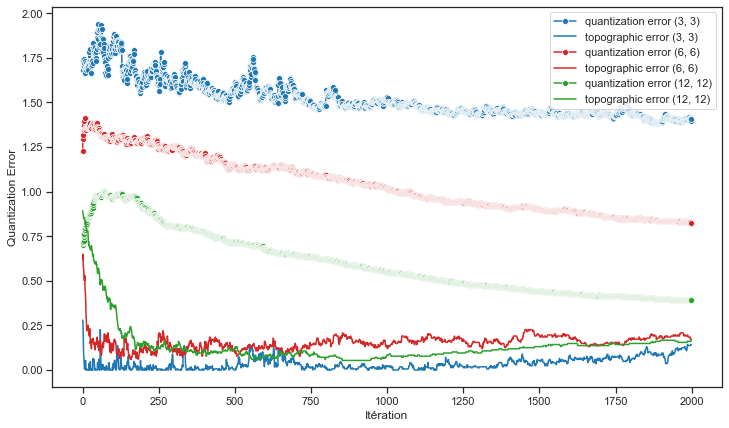

In [53]:
data = df_profiles_scaled.values

list_shapes = [(3,3), (6,6), (12,12)]
list_colors = ['tab:blue', 'tab:red', 'tab:green']

sns.set_theme('notebook')
sns.set_style("ticks")


plt.figure(figsize=(12, 7))

for i in range(3):

    som_shape = list_shapes[i]
    color = list_colors[i]

    som = MiniSom(som_shape[0], som_shape[1], 15, sigma=1.0, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)
    som.random_weights_init(data = data)

    max_iter = 2000
    q_error = []
    t_error = []

    for i in range(max_iter):
        rand_i = np.random.randint(len(data))
        som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
        q_error.append(som.quantization_error(data))
        t_error.append(som.topographic_error(data))

    sns.lineplot(x = np.arange(max_iter), y = q_error, label='quantization error '+str(som_shape), marker='o', color=color)
    sns.lineplot(x = np.arange(max_iter), y = t_error, label='topographic error '+str(som_shape), color=color)


plt.ylabel('Quantization Error')
plt.xlabel('Itération')
plt.legend()
plt.show()


<Figure size 720x720 with 0 Axes>

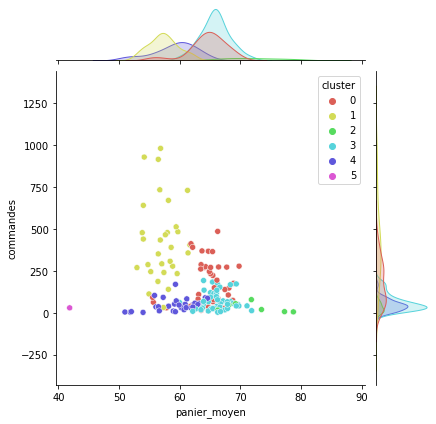

In [38]:
data = df_profiles_scaled.values

som_shape = (2,3)

som = MiniSom(som_shape[0], som_shape[1], 15, sigma=0.4, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)
som.random_weights_init(data = data)
som.train_random(data = data, num_iteration = 1000)
winner_coordinates = np.array([som.winner(x) for x in data]).T

# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
df_profiles['cluster'] = cluster_index

plt.figure(figsize=[10,10])
sns.jointplot(data=df_profiles, x='panier_moyen',y='commandes', hue='cluster', palette=sns.color_palette("hls", len(set(df_profiles['cluster'] ))))

In [39]:
with open('som', 'wb') as f:
    pickle.dump(som, f)

In [28]:
data = df_profiles_scaled.values


som = read_pickle('../app/static/models/som_model')

winner_coordinates = np.array([som.winner(x) for x in data]).T

# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (2,3))
df_profiles['cluster'] = cluster_index

<Figure size 720x720 with 0 Axes>

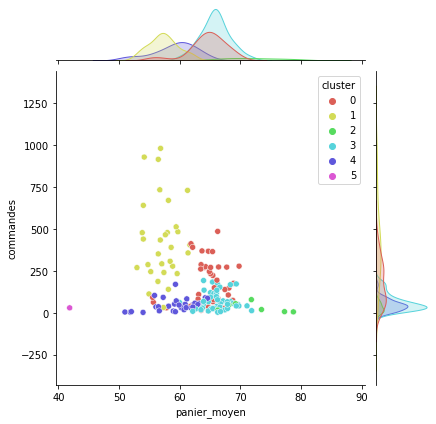

In [25]:
plt.figure(figsize=[10,10])
sns.jointplot(data=df_profiles, x='panier_moyen',y='commandes', hue='cluster', palette=sns.color_palette("hls", len(set(df_profiles['cluster'] ))))

<AxesSubplot:xlabel='sigma', ylabel='silhouette_score'>

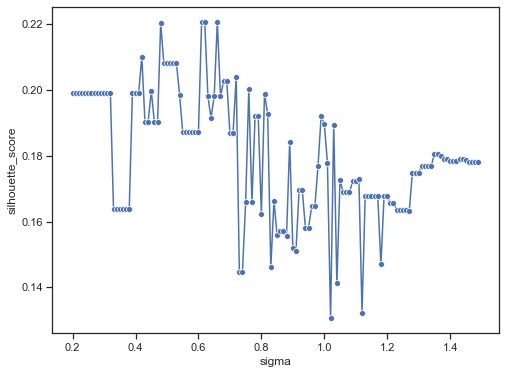

In [89]:
df_resultats = pd.DataFrame(columns=['sigma','silhouette_score'])

i = 0

for sigma in np.arange(0.2,1.5,0.01):

    som = MiniSom(som_shape[0], som_shape[1], 15, sigma=sigma, learning_rate=0.5, neighborhood_function='gaussian', random_seed=10)
    som.random_weights_init(data = data)
    som.train_random(data = data, num_iteration = 800)
    winner_coordinates = np.array([som.winner(x) for x in data]).T

    # coordinates to a monodimensional index
    cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
    df_profiles['cluster'] = cluster_index

    # Evaluate
    df_resultats.loc[i,'sigma'] = sigma
    df_resultats.loc[i,'silhouette_score'] = silhouette_score(df_profiles_scaled, cluster_index)

    i+=1

plt.figure(figsize=[8,6])

sns.lineplot(data=df_resultats, x="sigma", y="silhouette_score", marker='o')

# Affichage

In [10]:
df_profiles['cluster'] = kmeans.labels_

In [26]:
hist, bins

(array([1, 2, 0, 2, 6, 3, 3, 8, 6, 4, 7, 9, 4, 0, 2, 1]),
 array([52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72]))

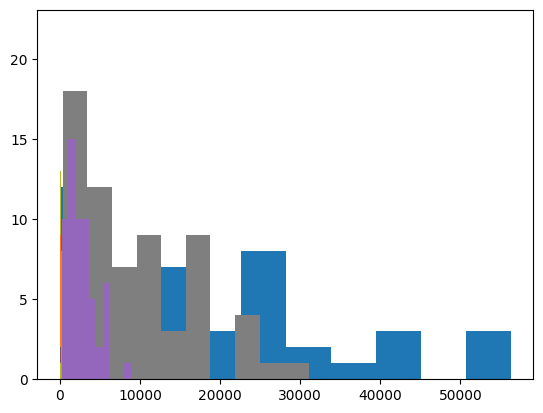

In [87]:
df_profiles['cluster'] = kmeans.labels_

round_kpi = {
    'ca': -3,
    'commandes': -1,
    'clients': -1,
    'panier_moyen': -2,
    'prix_moyen_article': -2,
    'nb_articles_moyen': 2,
    'frequence': 1
}

dict_res = {}

for cluster in df_profiles['cluster'].unique():

    cluster_index = str(cluster+1)
    dict_res[cluster_index] = {}

    df_profiles_cluster = df_profiles[df_profiles['cluster']==cluster]

    dict_res[cluster_index]['total'] = len(df_profiles_cluster)

    dict_res[cluster_index]['types'] = {
        'age': 'string',
        'genre':'string',
        'revenus':'string',
        'localisation':'string',
        'ca':'float',
        'commandes':'float',
        'clients':'float',
        'panier_moyen':'float',
        'prix_moyen_article':'float',
        'nb_articles_moyen':'float',
        'frequence':'float'
    }

    for col in ['age','genre','revenus','localisation']:

        value_counts = df_profiles_cluster[col].value_counts().to_dict()
        dict_res[cluster_index][col] = [[key,val] for key,val in value_counts.items()]

    for col in ['ca', 'commandes', 'panier_moyen', 'prix_moyen_article', 'clients', 'nb_articles_moyen', 'frequence']:

        counts, bins, bars = plt.hist(df_profiles_cluster[col], bins=10)
        l_hist = [list(a) for a in zip(bins, counts)]
        dict_res[cluster_index][col] = l_hist


In [72]:
df_profiles_cluster[col]

89    4.721684
Name: frequence, dtype: float64

In [86]:
from pprint import pprint
pprint(dict_res)

{'1': {'age': [['18-24', 1]],
       'ca': [[1544.137331257478, 0.0],
              [1544.237331257478, 0.0],
              [1544.3373312574781, 0.0],
              [1544.437331257478, 0.0],
              [1544.5373312574782, 0.0],
              [1544.637331257478, 1.0],
              [1544.737331257478, 0.0],
              [1544.8373312574781, 0.0],
              [1544.937331257478, 0.0],
              [1545.0373312574782, 0.0]],
       'clients': [[19.989275929067546, 0.0],
                   [20.089275929067547, 0.0],
                   [20.189275929067545, 0.0],
                   [20.289275929067546, 0.0],
                   [20.389275929067544, 0.0],
                   [20.489275929067546, 1.0],
                   [20.589275929067547, 0.0],
                   [20.689275929067545, 0.0],
                   [20.789275929067546, 0.0],
                   [20.889275929067544, 0.0]],
       'commandes': [[28.885034363377414, 0.0],
                     [28.985034363377416, 0.0],
        

<Figure size 640x480 with 0 Axes>

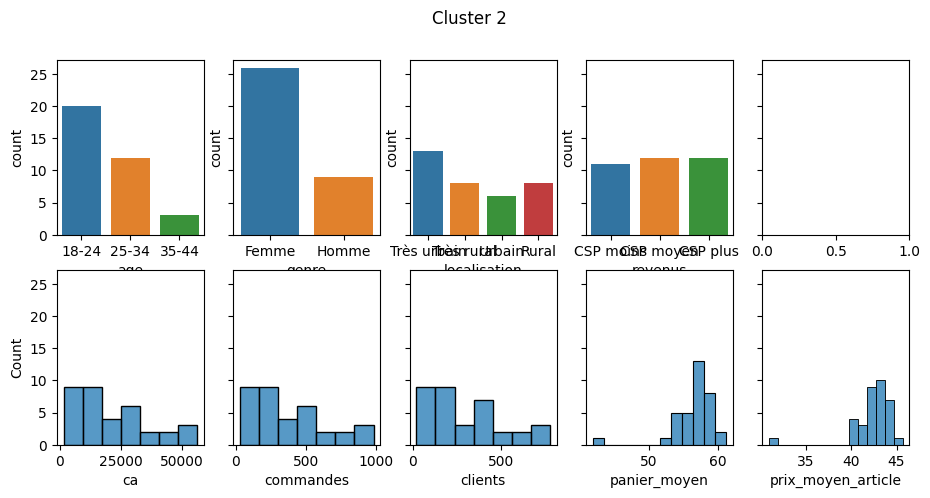

<Figure size 640x480 with 0 Axes>

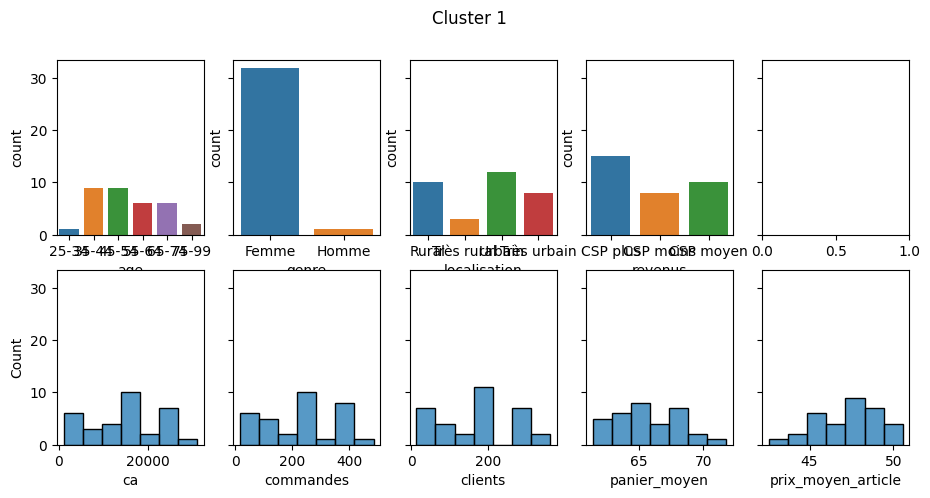

<Figure size 640x480 with 0 Axes>

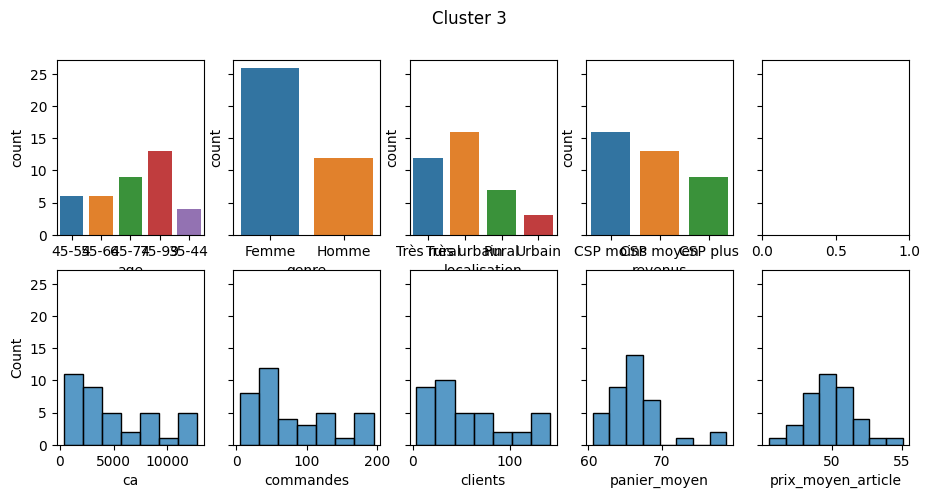

<Figure size 640x480 with 0 Axes>

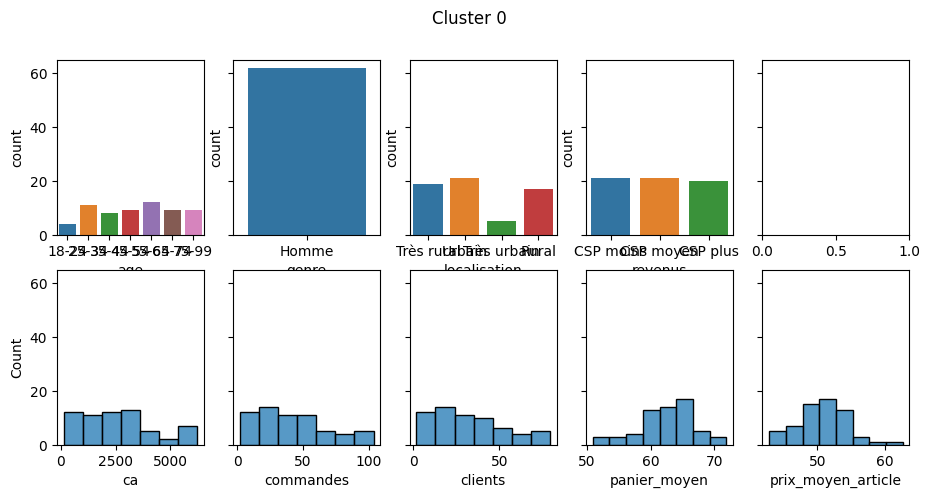

In [212]:
for cluster in df_profiles['cluster'].unique():
    data = df_profiles[df_profiles['cluster']==cluster]
    plt.figure()
    i=0

    fig, axes = plt.subplots(2, 5, figsize=(11, 5), sharey=True)
    fig.suptitle('Cluster '+str(cluster))

    for col in ['age','genre','localisation','revenus']:
        sns.countplot(x=col, data=data, ax=axes[0,i])
        i+=1
    
    i=0
    for col in ['ca','commandes','clients','panier_moyen','prix_moyen_article']:
        sns.histplot(data[col], label=col, ax=axes[1,i])
        i+=1

    plt.show()